## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import spacy
from transformers import AutoTokenizer, AutoModelForMaskedLM
from predictor import Predictor
from tqdm.auto import tqdm
import torch

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )
    torch.set_float32_matmul_precision('high')

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
GPU: NVIDIA RTX A6000
GPU Memory: 50.93 GB


In [2]:
# Load the dataset
df = pd.read_csv("../data/ellipsis_raw_rater_scores_anon_all_essay.csv")
print(f"Loaded {len(df)} essays")
print(f"\nColumns: {list(df.columns)}")
df.head()

Loaded 8890 essays

Columns: ['Filename', 'Text', 'Rater_1', 'Overall_1', 'Cohesion_1', 'Syntax_1', 'Vocabulary_1', 'Phraseology_1', 'Grammar_1', 'Conventions_1', 'Identifying_Info_1', 'Rater_2', 'Overall_2', 'Cohesion_2', 'Syntax_2', 'Vocabulary_2', 'Phraseology_2', 'Grammar_2', 'Conventions_2', 'Identifying_Info_2']


,Filename,Text,Rater_1,Overall_1,Cohesion_1,Syntax_1,Vocabulary_1,Phraseology_1,Grammar_1,Conventions_1,Identifying_Info_1,Rater_2,Overall_2,Cohesion_2,Syntax_2,Vocabulary_2,Phraseology_2,Grammar_2,Conventions_2,Identifying_Info_2
0,2021000071.txt,"To the Principal,\r\n\r\nI think that policy 1...",rater_1,3,3,4,4,4,5,3,0,rater_2,3,4,3,3,3,3,3,0
1,2021000501.txt,"Dear, TEACHER_NAME\r\n\r\nI think phone policy...",rater_1,3,3,2,3,3,3,2,0,rater_2,3,4,3,4,3,4,3,0
2,2021000535.txt,"Dear, Principal\r\n\r\nIn my opinion, I think ...",rater_1,3,2,3,2,2,3,3,0,rater_2,3,3,3,4,3,3,4,0
3,2021000667.txt,PHONES\r\n\r\nDear principal students should h...,rater_1,3,2,3,3,3,3,3,0,rater_2,3,3,3,3,3,4,3,0
4,2021000683.txt,phones\r\n\r\ni think phones should be allowed...,rater_1,3,2,3,3,3,3,3,0,rater_2,3,2,2,3,3,3,2,0


## 2. Load Models

In [3]:
# Load spaCy for tokenization
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_lg")
print("✓ spaCy loaded")

Loading spaCy model...
✓ spaCy loaded


In [4]:
# Load ModernBERT model and tokenizer
model_name = "answerdotai/ModernBERT-base"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

print("✓ ModernBERT loaded")

Loading answerdotai/ModernBERT-base...
✓ ModernBERT loaded


In [5]:
# Initialize predictor
device = "cuda" if torch.cuda.is_available() else "cpu"
window_size = 64
batch_size = 32

predictor = Predictor(
    tokenizer=tokenizer,
    model=model,
    model_type="masked",
    batch_size=batch_size,
    device=device,
)

print("Predictor initialized:")
print("  Model type: masked")
print(f"  Window size: {window_size}")
print(f"  Batch size: {batch_size}")
print(f"  Device: {device}")

Predictor initialized:
  Model type: masked
  Window size: 64
  Batch size: 32
  Device: cuda


## 3. Process Essays and Calculate Predictability

In [6]:
# Storage for results
results = {"mean_loss": [], "mean_prob": [], "mean_entropy": []}

# Process each essay
print(f"Processing {len(df)} essays...\n")

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Calculating predictability"):
    text = row["Text"]

    # Skip if text is missing or empty
    if pd.isna(text) or text.strip() == "":
        results["mean_loss"].append(None)
        results["mean_prob"].append(None)
        results["mean_entropy"].append(None)
        continue

    try:
        # Process with spaCy
        doc = nlp(text)

        # Calculate predictability
        doc_pred = predictor(doc, window_size=window_size)

        # Store aggregate metrics
        results["mean_loss"].append(doc_pred.mean_loss)
        results["mean_prob"].append(
            sum(t.mean_prob for t in doc_pred) / len(doc_pred)
        )
        results["mean_entropy"].append(doc_pred.mean_entropy)

    except Exception as e:
        print(f"\nError processing essay {idx} (Filename: {row['Filename']}): {e}")
        results["mean_loss"].append(None)
        results["mean_prob"].append(None)
        results["mean_entropy"].append(None)

print("\n✓ Processing complete!")

Processing 8890 essays...



Calculating predictability:   0%|          | 0/8890 [00:00<?, ?it/s]

Calculating predictability: 100%|██████████| 8890/8890 [1:45:50<00:00,  1.40it/s]  


✓ Processing complete!


## 4. Add Results to DataFrame and Save

In [11]:
# Add new columns to dataframe
df["mean_loss"] = results["mean_loss"]
df["mean_prob"] = results["mean_prob"]
df["mean_entropy"] = results["mean_entropy"]

# Display summary statistics
print("Summary statistics for predictability metrics:\n")
print(df[["mean_loss", "mean_prob", "mean_entropy"]].describe())

# Show first few rows
print("\nFirst few rows with new metrics:")
df[["Filename", "mean_loss", "mean_prob", "mean_entropy"]].head(10)

Summary statistics for predictability metrics:

         mean_loss    mean_prob  mean_entropy
count  8890.000000  8890.000000   8890.000000
mean      1.768154     0.504074      1.705644
std       0.612834     0.099267      0.530600
min       0.488503     0.000291      0.675050
25%       1.351637     0.448328      1.350426
50%       1.642508     0.518022      1.589952
75%       2.031324     0.573656      1.925344
max       9.497389     0.787270      5.694413

First few rows with new metrics:


,Filename,mean_loss,mean_prob,mean_entropy
0,2021000071.txt,1.292886,0.603168,1.274417
1,2021000501.txt,1.692086,0.511293,1.505809
2,2021000535.txt,1.368156,0.560669,1.401398
3,2021000667.txt,1.799001,0.448328,1.748560
4,2021000683.txt,1.309744,0.577187,1.362033
5,2021000705.txt,1.861015,0.486352,1.772980
6,2021000748.txt,1.417613,0.577480,1.289564
7,2021000756.txt,1.603431,0.511528,1.598423
8,2021001001.txt,1.498487,0.495330,1.532694
9,2021001035.txt,1.646023,0.496363,1.555399


In [12]:
# Save to file
output_path = "../data/ellipsis_raw_rater_scores_anon_all_essay_w_predictability.csv"
df.to_csv(output_path, index=False)
print(f"✓ Results saved to: {output_path}")
print(f"  Total essays: {len(df)}")
print(f"  Columns: {len(df.columns)}")

✓ Results saved to: ../data/ellipsis_raw_rater_scores_anon_all_essay_w_predictability.csv
  Total essays: 8890
  Columns: 23


## 5. Quick Validation and Visualization

In [13]:
# Check for any missing values
missing_counts = df[["mean_loss", "mean_prob", "mean_entropy"]].isna().sum()
print("Missing values per column:")
print(missing_counts)

if missing_counts.sum() > 0:
    print("\nEssays with missing predictability scores:")
    print(df[df["mean_loss"].isna()][["Filename", "Text"]].head())

Missing values per column:
mean_loss       0
mean_prob       0
mean_entropy    0
dtype: int64


In [ ]:
# Fine-grained output for first ~20 words of 3 different essays
# to verify metrics are aligned to correct tokens

sample_indices = [0, 100, 500]  # Different essays

for essay_idx in sample_indices:
    row = df.iloc[essay_idx]
    text = row['Text']
    
    print("=" * 80)
    print(f"ESSAY {essay_idx}: {row['Filename']}")
    print("=" * 80)
    print(f"Text (first 300 chars): {text[:300]}...")
    print()
    
    # Process with spaCy
    doc = nlp(text)
    
    # Get predictability for all tokens
    result = predictor(doc, window_size=window_size)
    
    # Display first 20 tokens with metrics
    print(f"{'Idx':<4} {'Token':<20} {'Loss (Surprisal)':<18} {'Prob':<12} {'Entropy':<12} {'#Subwords':<10}")
    print("-" * 80)
    
    for i, (token, token_pred) in enumerate(zip(doc, result.tokens)):
        if i >= 20:
            print("... (truncated)")
            break
        
        # Format token text (escape whitespace)
        token_text = repr(token.text)[1:-1]  # Remove quotes from repr
        if len(token_text) > 18:
            token_text = token_text[:15] + "..."
        
        print(f"{i:<4} {token_text:<20} {token_pred.mean_loss:<18.4f} {token_pred.mean_prob:<12.6f} {token_pred.mean_entropy:<12.4f} {len(token_pred):<10}")
    
    print(f"\nTotal tokens: {len(doc)}, Tokens with predictions: {len(result.tokens)}")
    print(f"Document mean_loss: {result.mean_loss:.4f}")
    print()

ESSAY 0: 2021000071.txt
Text (first 300 chars): To the Principal,

I think that policy 1 is the best choice. I think this because that's what all students from school need cell phones. The students might need cell phones because, maybe they don't know who to go with or if their mom or dad is picking them up. Another reason to bring cell phones ...

Idx  Token                Loss (Surprisal)   Prob         Entropy      #Subwords 
--------------------------------------------------------------------------------
0    To                   1.2854             0.276542     2.9821       1         
1    the                  0.2186             0.803683     1.2355       1         
2    Principal            9.0539             0.000117     4.7447       1         
3    ,                    7.2176             0.013703     0.9531       2         
4    \r\n\r\n             0.0329             0.967640     0.2517       2         
5    I                    0.1331             0.875414     0.6100       1    

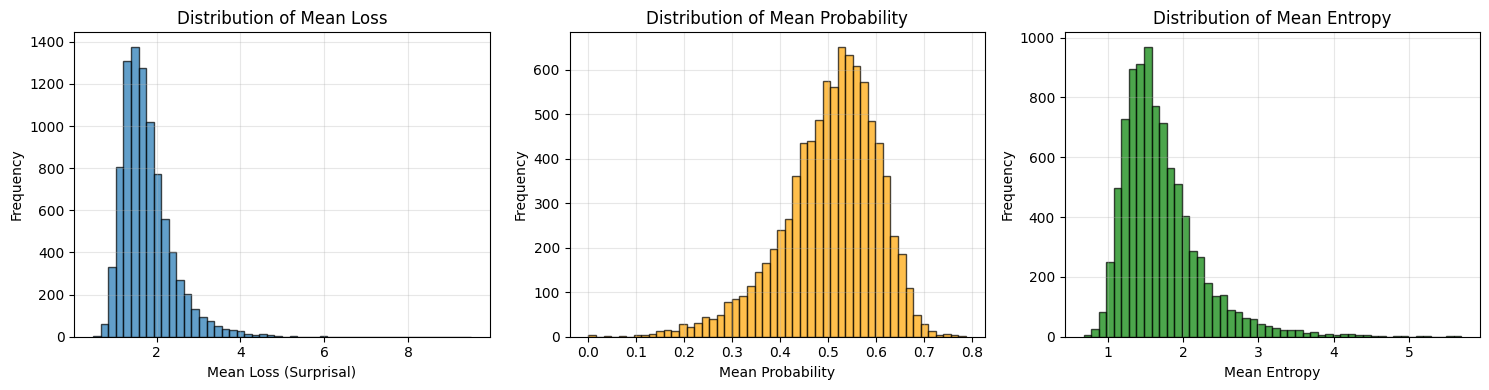

In [14]:
# Optional: Create simple visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Mean Loss distribution
axes[0].hist(df["mean_loss"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Mean Loss (Surprisal)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Mean Loss")
axes[0].grid(alpha=0.3)

# Mean Probability distribution
axes[1].hist(
    df["mean_prob"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="orange"
)
axes[1].set_xlabel("Mean Probability")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Mean Probability")
axes[1].grid(alpha=0.3)

# Mean Entropy distribution
axes[2].hist(
    df["mean_entropy"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="green"
)
axes[2].set_xlabel("Mean Entropy")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Mean Entropy")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()